In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os, glob
from scipy.optimize import minimize
from scipy.stats import beta as beta_dist


# psuedo

```
1. there's a uniform dist of stim, ranging from -.38 to .38, inclusive, in multiples of .04

2. there is div_pos = 0

3. asymmetric #coins are gained or lost based whether output is on the same side of div_pos as stim_pos. specifically, payoffs:
        true_neg (tn), true_pos (tp), false_neg (fn), false_pos (fp) = 1, 3, -1, -3

4. there is a response bias towards the boundary, bound_bias. ignore this for now. 

5. resp depends on noised_stim_pos, PAYOFFS?, and risk_prone (seeking if > 0, averse if < 0). specifically,

        generate agents with risk_prone vals -1, -.6, -.2, .2, .6, 1
        rep = noised_stim_pos

        for stim in stim_pos:
                
                if risk_prone > 0: # risk seeking
                        
                        if rep < 0:
                                p_seek increases as rep becomes closer to 0, with faster rises for greater |risk_prone|
                                resp = err, with prob = p_seek
                                          rep, with prob = 1 - p_seek

                if risk_prone < 0: # risk averse
                        
                        if rep > 0:
                                p_avert increases as rep becomes closer to 0, with faster rises for greater |risk_prone|
                                resp = -err, with prob = p_avert
                                          rep, with prob = 1 - p_avert


plot hist of noised_stim_pos
for each agent across 2*3 subplots, plot stim_pos vs resp

# note: in the near future, could frame this as a maximizing coins, minimizing switching, and minimizing distance from boundary problem

                # pull towards boundary, with stronger pulls for farther positions
                rep = noised_stim_pos/(noised_stim_pos * bound_bias)

# v1.

In [ ]:
def simulate(fake_stim, noise = .2):
    fake_resp = fake_stim + np.random.normal(0, noise, len(fake_stim))
    return fake_resp

def loglik(noise, fake_stim, fake_resp):
    # Compute the log-likelihood of the data given the model
    resid = fake_resp - fake_stim
    # essentialy p(fake_resp|fake_stim), which takes a particular formula for gaussians
    # then multiply for all fake_stim, and sum-log it (easier)
    ll = -0.5 * np.sum(np.log(2*np.pi*noise**2) + (resid**2)/(noise**2))
    return ll

def fit(fake_stim, fake_resp, init_noise=0.5):
    # Fit the model parameters to the data by minimizing the negative log-likelihood
    nll = lambda sigma: -loglik(sigma[0], fake_stim, fake_resp)
    result = minimize(nll, [init_noise], bounds=[(1e-6, None)])
    return result.x[0] # first & only param

# fake param recovery
fake_stim = np.arange(-0.38, 0.381, 0.04)
fake_stim = np.tile(fake_stim, 50)
true_noise = 0.2

fake_resp = simulate(fake_stim, noise=true_noise)
est_noise = fit(fake_stim, fake_resp)
print("True:", true_noise, "Est:", est_noise)

True: 0.2 Est: 0.2001473275156845


real data

In [3]:
df = pd.read_csv('../../results/all_subjs_clean.csv')

stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values

est_noise = fit(stim, resp)
print("Estimated:", est_noise)

Estimated: 0.1603107570035981


# v2.

models

In [4]:
def gauss(params, stim):
    '''Simple Gaussian noise: predicts responses as Normal(stim, sigma).'''
    sigma = params[0]
    mu = stim
    return mu, np.full_like(stim, sigma)

def gauss_bias(params, stim):
    '''Gaussian noise + bias: Normal(stim + bias, sigma).'''
    sigma, bias = params
    mu = stim + bias
    return mu, np.full_like(stim, sigma)

def beta_(params, stim_normed):
    '''Beta noise: predicts responses as Beta(stim, a, b).'''
    a, b = params
    return np.full_like(stim_normed, a), np.full_like(stim_normed, b)

def beta_mean_kappa(params, stim01, EPS=1e-9):
    """params = (kappa,), mean=stim01; kappa>0 controls spread."""
    (kappa,) = params
    mu = np.clip(stim01.astype(float), EPS, 1-EPS) # guards endpoints
    a  = mu * kappa
    b  = (1 - mu) * kappa
    return a, b

def beta_mean_kappa_link(params, stim01, EPS=1e-9):
    eta0, eta1 = params
    mu = np.clip(stim01.astype(float), EPS, 1-EPS)          # clip μ
    kappa = softplus(eta0 + eta1 * np.abs(mu - 0.5)) + 1e-6 # κ>0
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

# --- MODEL: Beta with logistic mean and constant kappa ---
# params = (w0, w1, eta)  where  mu = sigmoid(w0 + w1*(stim01-0.5)),
#                           kappa = softplus(eta) + 1e-6
def beta_logistic_mean(params, stim01, EPS=1e-9):
    w0, w1, eta = params
    mu = 1.0 / (1.0 + np.exp(-(w0 + w1*(stim01 - 0.5))))
    mu = np.clip(mu.astype(float), EPS, 1-EPS)
    kappa = softplus(eta) + 1e-6
    a, b = mu * kappa, (1 - mu) * kappa
    return a, b

def norm01(x, lo=-.38, hi=.38):
    normed = (x - lo) / (hi - lo)
    clipped = np.clip(normed, 1e-6, 1-1e-6)
    return clipped

def softplus(z): return np.log1p(np.exp(z))


fitting & comparing

In [5]:
def gauss_ll(gauss_model, params, stim, resp):
    '''Log-likelihood for Gaussian continuous responses.'''
    mu, sigma = gauss_model(params, stim)
    
    resid = resp - mu
    ll = -0.5 * np.sum(np.log(2*np.pi*sigma**2) + (resid**2)/(sigma**2))
    return ll

def beta_ll(beta_model, params, normed_stim, resp, EPS=1e-9):
    '''Log-likelihood for Beta continuous responses.'''
    a, b = beta_model(params, normed_stim)
    resp = np.clip(resp.astype(float), EPS, 1 - EPS)  # guard endpoints
    ll = np.sum(beta_dist.logpdf(resp, a=a, b=b))
    return ll

def fit_model(model, stim, resp, init_params, bounds):
    '''Fit a model to the data by minimizing the negative log-likelihood.'''

    # choose the right likelihood function
    ll_func = beta_ll if model in beta_models else gauss_ll

    # wrapper: given parameters, compute *negative* log-likelihood
    def nll(theta):
        loglik = ll_func(model, theta, stim, resp)
        return -loglik
    
    result = minimize(nll, init_params, bounds=bounds)
    return result.x, -result.fun # params, -ll

def bic(loglik, num_params, num_trials):
    '''Bayesian Information Criterion (BIC) for model comparison.'''
    return -2*loglik + num_params * np.log(num_trials)


data

In [6]:
# real data
stim = df['stim_pos_aligned'].values
resp = df['chosen_pos_aligned'].values
normed_stim, normed_resp = norm01(stim), norm01(resp)

# simulated
np.random.seed(0)

# gaussian
bias, noise = 0, .1
resp_gauss_sim = normed_stim + bias + np.random.normal(0, noise, len(normed_stim))
# beta
kappa = 5.0
a, b = beta_mean_kappa([kappa], normed_stim)
resp_beta_sim = np.random.beta(a,b)

fitting

In [7]:
fits = []
beta_models = {beta_, beta_mean_kappa, beta_mean_kappa_link, beta_logistic_mean}
gauss_models = {gauss, gauss_bias}

# 1. gauss model
params1, ll1 = fit_model(gauss, normed_stim, normed_resp, init_params=[0.5], bounds=[(1e-6,None)])
bic1 = bic(ll1, len(params1), len(normed_stim))
fits.append({"model":"gauss","params":params1,"LL":ll1,"BIC":bic1})

# 2. beta model
params3, ll3 = fit_model(beta_mean_kappa, normed_stim, normed_resp, init_params=[5.0], bounds=[(1e-6,None)]) # real
# params3, ll3 = fit_model(beta_mean_kappa, normed_stim, resp_beta_sim, init_params=[5.0], bounds=[(1e-6,None)]) # fake
bic3 = bic(ll3, len(params3), len(normed_stim))
fits.append({"model":"beta", "params":params3, "LL":ll3, "BIC":bic3})

# 3. beta + link model
params4, ll4 = fit_model(beta_mean_kappa_link, normed_stim, normed_resp, init_params=[1.0, 0.0],   # start flat
                         bounds=[(None, None), (None, None)]   # unconstrained; softplus keeps κ>0
)
bic4 = bic(ll4, len(params4), len(normed_stim))
fits.append({"model":"beta + link", "params":params4, "LL":ll4, "BIC":bic4})

# 4. beta + logistic mean model
params_blm, ll_blm = fit_model(beta_logistic_mean,  normed_stim, normed_resp, init_params=[0.0, 3.0, 1.0],     # bias ~0, slope >0 start, eta ~1
                               bounds=[(None,None), (None,None), (None,None)]
)
bic_blm = bic(ll_blm, len(params_blm), len(normed_stim))
fits.append({"model":"beta + logistic mean", "params":params_blm, "LL":ll_blm, "BIC":bic_blm})

# Sort by BIC
fits_sorted = sorted(fits, key=lambda x: x["BIC"])
fits_sorted

[{'model': 'beta + logistic mean',
  'params': array([-0.04532754,  2.93414477,  2.37503349]),
  'LL': np.float64(448.9263781283288),
  'BIC': np.float64(-876.0355610789475)},
 {'model': 'gauss',
  'params': array([0.20989787]),
  'LL': np.float64(204.76171519627692),
  'BIC': np.float64(-402.2510319999838)},
 {'model': 'beta + link',
  'params': array([1.209094  , 6.88025472]),
  'LL': np.float64(-1329.8215551352846),
  'BIC': np.float64(2674.1879070557093)},
 {'model': 'beta',
  'params': array([2.85002276]),
  'LL': np.float64(-1395.7623888463977),
  'BIC': np.float64(2798.7971760853657)}]

Mean fit: a=0.138, b=0.709  (ideal Beta has a≈0, b≈1)
Var fit:  kappâ(median)=3.981


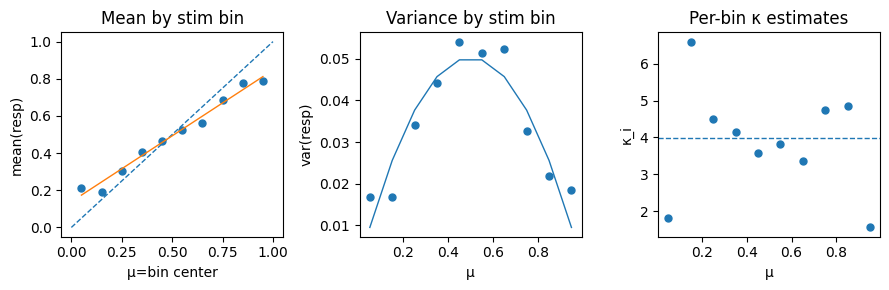

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EPS = 1e-9
def norm01(x, lo=-.38, hi=.38):
    return np.clip((x - lo) / (hi - lo), EPS, 1-EPS)

# 1) prepare data in (0,1)
stim01 = norm01(df['stim_pos_aligned'].values)
resp01 = norm01(df['chosen_pos_aligned'].values)

# 2) bin by stim01
bins = np.linspace(0, 1, 11)            # 10 bins
bin_id = np.digitize(stim01, bins) - 1
centers = 0.5 * (bins[:-1] + bins[1:])

def agg(x, f): 
    return np.array([f(x[bin_id==i]) if np.any(bin_id==i) else np.nan
                     for i in range(len(centers))])

m_resp = agg(resp01, np.mean)            # empirical mean per bin
v_resp = agg(resp01, lambda z: np.var(z, ddof=1))   # empirical var per bin
n_resp = agg(resp01, lambda z: z.size)

# 3) mean check: is mean(resp|stim) ≈ stim?
# fit a simple line m_resp ≈ a + b * centers (ignore empty bins)
ok = ~np.isnan(m_resp)
X = np.vstack([np.ones(ok.sum()), centers[ok]]).T
a_hat, b_hat = np.linalg.lstsq(X, m_resp[ok], rcond=None)[0]

# 4) variance check: does var ≈ μ(1-μ)/(κ+1)?
# per-bin kappa_i = μ(1-μ)/var_i - 1  (only where var>0)
valid = ok & (v_resp > 0)
kappa_i = centers[valid]*(1-centers[valid]) / v_resp[valid] - 1
kappa_hat = np.median(kappa_i) if kappa_i.size else np.nan
v_pred = centers*(1-centers) / (kappa_hat + 1) if np.isfinite(kappa_hat) else np.full_like(centers, np.nan)

print(f"Mean fit: a={a_hat:.3f}, b={b_hat:.3f}  (ideal Beta has a≈0, b≈1)")
print(f"Var fit:  kappâ(median)={kappa_hat:.3f}")

# 5) quick plots
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.scatter(centers[ok], m_resp[ok], s=25)
plt.plot([0,1],[0,1],'--',lw=1)               # ideal
plt.plot(centers, a_hat + b_hat*centers, lw=1)
plt.title("Mean by stim bin"); plt.xlabel("μ=bin center"); plt.ylabel("mean(resp)")

plt.subplot(1,3,2)
plt.scatter(centers[valid], v_resp[valid], s=25)
if np.isfinite(kappa_hat):
    plt.plot(centers, v_pred, lw=1)
plt.title("Variance by stim bin"); plt.xlabel("μ"); plt.ylabel("var(resp)")

plt.subplot(1,3,3)
plt.scatter(centers[valid], kappa_i, s=25)
plt.axhline(kappa_hat, ls='--', lw=1)
plt.title("Per-bin κ estimates"); plt.xlabel("μ"); plt.ylabel("κ_i")

plt.tight_layout(); plt.show()


plots

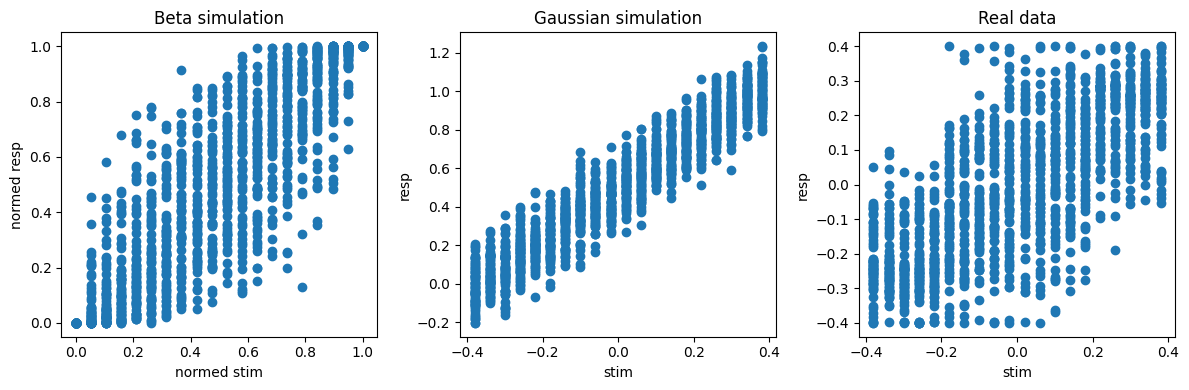

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(4*3, 4*1))
axs, ax = axs.flatten(), 0

axs[ax].scatter(norm01(stim), resp_beta_sim)
axs[ax].set(xlabel='normed stim', ylabel='normed resp', title='Beta simulation')
ax += 1

axs[ax].scatter(stim, resp_gauss_sim)
axs[ax].set(xlabel='stim', ylabel='resp', title='Gaussian simulation')
ax += 1

axs[ax].scatter(stim, resp)
axs[ax].set(xlabel='stim', ylabel='resp', title='Real data')

plt.tight_layout()
plt.show()

In [10]:
# from scipy.special import expit

# # Random number generator (fix seed for reproducibility)
# rng = np.random.default_rng(0)

# def simulate_responses(n_repeats=10, stim_noise=0.2, delta=0.05, k_p=30, k_sigma=20):
#     """
#     Simulate responses for 20 stimulus positions around divider.
    
#     Parameters
#     ----------
#     n_repeats : int
#         Number of repeats per stimulus position
#     stim_noise : float
#         Base motor noise (larger = noisier responses)
#     delta : float
#         Shift added when risk bias triggers (left side, towards divider)
#     k_p : float
#         Steepness of logistic for risk probability
#     k_sigma : float
#         Steepness of logistic for noise decay on right side
#     """
    
#     # --- 1. Stimulus grid (20 values from -0.38 to 0.38) ---
#     stim_values = np.arange(-0.38, 0.381, 0.04)
#     stim = np.tile(stim_values, n_repeats)   # repeat each stim
#     n_trials = stim.size
#     div = 0
    
#     # --- 2. Internal noisy perception of stim ---
#     noisy_stim = stim + rng.normal(0, stim_noise, n_trials)
    
#     # --- 3. Risk probability (only for noisy_stim < divider) ---
#     p_risk = np.where(noisy_stim < div, expit(k_p*(noisy_stim - div)), 0)
    
#     # --- 4. Logistic noise profile (right side only) ---
#     d = np.maximum(noisy_stim, div)  # distance on right
#     scale = 1/(1 + np.exp(-k_sigma*(d - 0.2)))  # logistic shape
#     sigma = np.where(noisy_stim <= div, stim_noise, stim_noise*scale)
    
#     # --- 5. Generate responses trial by trial ---
#     resp = np.zeros_like(noisy_stim)
#     for i, x in enumerate(noisy_stim):
#         if x < div:
#             # Left side: may "jump" towards divider with probability p_risk
#             if rng.random() < p_risk[i]:
#                 resp[i] = rng.normal(div + delta, sigma[i])
#             else:
#                 resp[i] = rng.normal(x, sigma[i])
#         else:
#             # Right side: response follows noisy_stim, with reduced noise
#             resp[i] = rng.normal(x, sigma[i])
    
#     return stim, noisy_stim, resp, p_risk, sigma


# # --- Example run ---
# stim, noisy_stim, resp, p_risk, sigma = simulate_responses(n_repeats=10, stim_noise=0.2)
# correct = np.sign(stim-div) == np.sign(resp-div)

# # --- Plot results ---
# plt.figure(figsize=(8,4))

# # Plot 1: Stimulus vs Response
# plt.subplot(1,2,1)
# for outcome in correct:
#     color = 'green' if outcome else 'red'
#     plt.scatter(stim[correct == outcome], resp[correct == outcome], alpha=0.5, s=10, color=color)
# # plt.scatter(stim, resp, alpha=0.5, s=10)
# plt.axvline(0, color='k', linestyle='--', alpha=0.7)
# plt.title("Stimulus vs Response")
# plt.xlabel("Stimulus")
# plt.ylabel("Response")

# # Plot 2: Noise and p_risk vs noisy_stim
# plt.subplot(1,2,2)
# plt.scatter(noisy_stim, sigma, alpha=0.5, s=10, label="Noise σ")
# plt.scatter(noisy_stim, p_risk, alpha=0.5, s=10, label="p_risk")
# plt.axvline(0, color='k', linestyle='--', alpha=0.7)
# plt.title("Noise & p_risk across trials")
# plt.xlabel("noisy_stim")
# plt.ylabel("Value")
# plt.legend()

# plt.tight_layout()
# plt.show()
